# YOLO v3 Finetuning on AWS

This series of notebooks demonstrates how to finetune pretrained YOLO v3 (aka YOLO3) using MXNet on AWS.

**This notebook** walks through using the [DeepSORT](https://github.com/haandol/mxnet-deepsort-yolo3) on Localhost.
We are going to capture mis-detected scenes in order to finetune YOLO3 object detector.

**Follow-on** the content of the notebooks shows:

* How to use MXNet YOLO3 pretrained model
* How to use Deep SORT with MXNet YOLO3
* How to create Ground-Truth dataset from images the model mis-detected
* How to finetune the model using the created dataset
* Load your finetuned model and Deploy Sagemaker-Endpoint with it using CPU instance.
* Load your finetuned model and Deploy Sagemaker-Endpoint with it using GPU instance.


## Prerequisites

This notebook is designed to be run in Localhost. To run it (and understand what's going on), you'll need:

* Anaconda (Python 3.6+)
* Basic familiarity with Python, Multi Object Tracking

# What does the DeepSORT do?

`DeepSORT` is one of the famous method for multiple object tracking.

It is the enhanced version of `SORT` which is uses `Kalman Filter` and `Hungarian Algorithm` to track objects.

First, object detector, such as SSD, Faster RCNN and YOLO, detects location of the objects, it sends locations to DeepSORT. DeepSORT extracts `appreance feature` using the deeplearning model from the locations. The algorithm uses it as a factor in process for matching tracking-id to each location.

In this notebook is focusing on the usage of the framework, so if you want more details please visit [DeepSORT](https://nanonets.com/blog/object-tracking-deepsort/#deep-sort) and [Computer Vsion for tracking](https://towardsdatascience.com/computer-vision-for-tracking-8220759eee85).

## Step 0: Create Conda Environment

In order to install the required packages, we need to set up a virtual environment first. 

```bash
$ conda create -n yolo-hol-env python=3.6
```

After installing the virtual environment, enter the following command to activate it.

```bash
$ source activate yolo-hol-env
```

## Step 1: Clone DeepSORT repository

As I mentioned before, DeepSORT is a method for object tracking.
There are many implementations out there. 
In this module we are going to use this [repository](https://github.com/haandol/mxnet-deepsort-yolo3) that is customized with MXNet YOLO3 for this workshop.

Clone repository with following command,

```bash
(yolo-hol-env) $ git clone https://github.com/haandol/mxnet-deepsort-yolo3 deepsort

.
├── LICENSE
├── README.md
├── deep_sort
├── demo.py
├── model_data
├── requirements.txt
├── tools
└── video.mp4
```

## Step 2: Install libraries and set configurations

In order to run `demo.py`, you should install some requirements.

```bash
(yolo-hol-env) $ pip install -r requirements.txt
```

## Step 3: Run demo.py

Now you are ready to run `demo.py`.

```bash
(yolo-hol-env) $ python demo.py --src video.mp4 --out-dir images --fps 10
...
INFO:deepsort:Skipped by time_since_update
INFO:deepsort:Skipped by time_since_update
INFO:deepsort:Skipped by time_since_update
INFO:deepsort:Skipped by time_since_update
INFO:deepsort:Frame #5 - Id: 1
INFO:deepsort:Frame #5 - Id: 2
INFO:deepsort:Frame #7 - Id: 1
...
INFO:deepsort:Missed obj: 90, Missed frame: 82
```

## Step 4: Check Results

As you noticed above, there are some mis-detected frames. The demo script store the scene into your `out_dir`, it is `images` in this case.

```bash
(yolo-hol-env) $ ls images
1.jpg
4.jpg
...
missed-76-2.jpg
missed-196-3.jpg
missed-217-3.jpg
missed-244-1.jpg
missed-340-6.jpg
missed-349-3.jpg
```

Stored `{frame_index}.jpg` image shows how the detector see the frame(scene), and `missed-{frame_index}-{track_id}.jpg` is the region where the `track_id` disappears in the `frame_index.jpg` scene.

In [3]:
import mxnet as mx
import gluoncv as gcv
from matplotlib import pyplot as plt

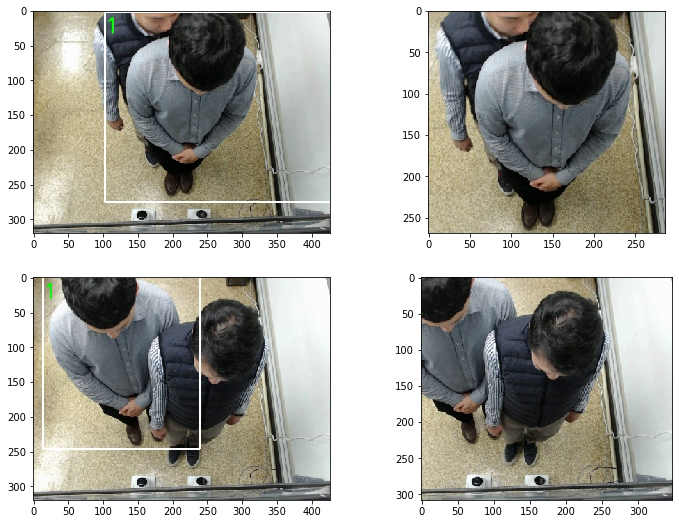

In [13]:
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

gcv.utils.viz.plot_image(mx.img.imread('Assets/76.jpg'), ax=ax1)
gcv.utils.viz.plot_image(mx.img.imread('Assets/missed-76-2.jpg'), ax=ax2)
gcv.utils.viz.plot_image(mx.img.imread('Assets/196.jpg'), ax=ax3)
gcv.utils.viz.plot_image(mx.img.imread('Assets/missed-196-3.jpg'), ax=ax4)

plt.show()

In the tracking workload, the worst case is switched `track_id` and it happened between  `238.jpg` and `241.jpg`.
In the scence, `1` track_id is switched to `3` that is assigned to the guy wearing navy vest originally.

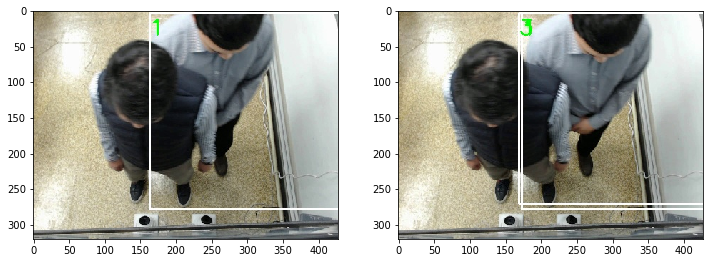

In [15]:
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

gcv.utils.viz.plot_image(mx.img.imread('Assets/238.jpg'), ax=ax1)
gcv.utils.viz.plot_image(mx.img.imread('Assets/241.jpg'), ax=ax2)

plt.show()

In next notebook, we are going to use Sagemaker Ground Truth to label `missed-{frame_index}-{track_id}.jpg` images with bounding box.